# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) &
        (df['price'] <= np.percentile(df['price'], 99.5)) &
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) &
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) &
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

- [ ] Make at least 1 partial dependence plot to explain your model.

In [4]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(
    train, random_state=42
)

train.shape, val.shape

((23883, 34), (7961, 34))

In [7]:
target = 'price'
features = ['bedrooms', 'bathrooms', 'longitude', 'latitude', 'interest_level']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [8]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.8435793987025704


In [9]:
encoder = ce.OrdinalEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.transform(X_test)
X_val_encode = encoder.transform(X_val)

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [11]:
X_val_encode.columns

Index(['bedrooms', 'bathrooms', 'longitude', 'latitude', 'interest_level'], dtype='object')

In [ ]:
!pip install pdpbox==0.2.0

In [20]:
from pdpbox.pdp import pdp_isolate,pdp_plot

feature = 'latitude'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val_encode,
    model_features=X_val_encode.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fed194a6e80>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fed195b5b70>})

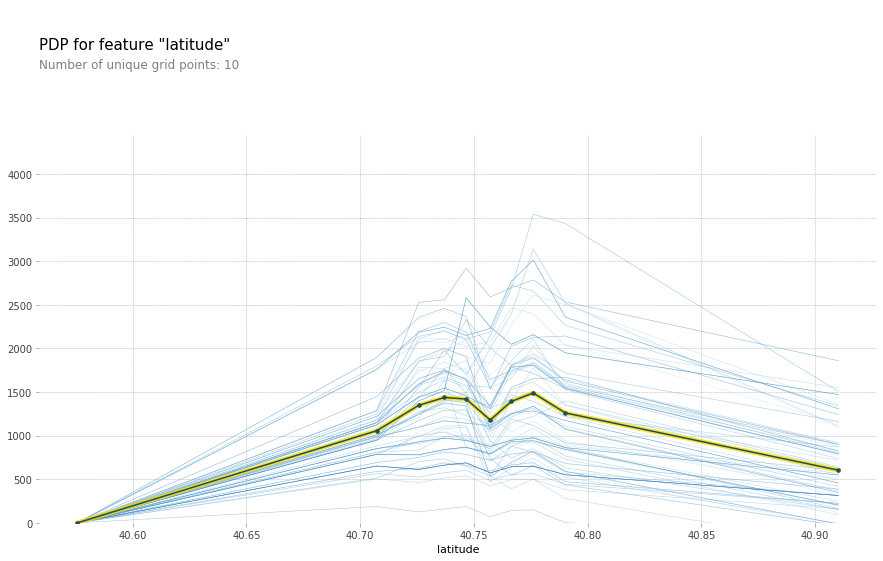

In [ ]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=.01)

- [ ] Make multiple PDPs with 2 features in interaction.

In [21]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [22]:
features2 = ['latitude', 'longitude']

interaction = pdp_interact(
    model=gb,
    dataset=X_val_encode,
    model_features = X_val_encode.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fed151ae9e8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fed177fa438>})

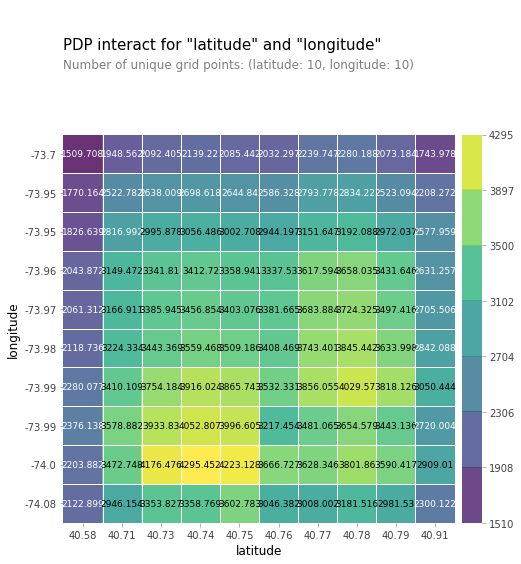

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features2)

- [ ] Use Plotly to make a 3D PDP.

In [ ]:
pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features2[1]
)[::-1]

In [ ]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns,
    y=pdp.index,
    z=pdp.values
)

layout= go.Layout(
    scene=dict(
        xaxis=dict(title=features2[0]),
        yaxis=dict(title=features2[1]),
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

- [X] Make at least 1 Shapley force plot to explain an individual prediction.

In [ ]:
#I must make a new model without a pipeline

encoder = ce.OrdinalEncoder()
model = XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)

X_train_encode = encoder.fit_transform(X_train)
model.fit(X_train_encode, y_train)

X_val_encode = encoder.transform(X_val)
print('Accuracy score', model.score(X_val_encode, y_val))

X_test_encode = encoder.transform(X_test)
y_pred= model.predict(X_test_encode)

Accuracy score 0.7564240900684898


In [ ]:
#get an individual row from the data above
row = X_train_encode.iloc[[0]]
row

,bedrooms,bathrooms,longitude,latitude,interest_level
40411,6,3.0,-73.955,40.7765,1


In [ ]:
#and it's prediction

y_train.iloc[[0]]

40411    7250
Name: price, dtype: int64

In [ ]:
#our model is about $400 off the true price
model.predict(row)

array([7664.4707], dtype=float32)

In [ ]:
import shap

explainer = shap.TreeExplainer(model) #explain the whole model
shap_values = explainer.shap_values(row) # use that explanation to show this row

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)